In [462]:
# Imports
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import random

In [463]:
df_train = pd.read_csv('equip_failures_training_set.csv')
df_test = pd.read_csv('equip_failures_test_set.csv')

## Exploratory data analysis

Counting the values of the target to find out how skewed our data is

In [464]:
df_train.target.value_counts()

0    59000
1     1000
Name: target, dtype: int64

# Understanding the histograms

In [465]:
# analyzing one of the sensors:
hist_cols = [i for i in df_train.columns if 'sensor7_' in i]
hist_cols

['sensor7_histogram_bin0',
 'sensor7_histogram_bin1',
 'sensor7_histogram_bin2',
 'sensor7_histogram_bin3',
 'sensor7_histogram_bin4',
 'sensor7_histogram_bin5',
 'sensor7_histogram_bin6',
 'sensor7_histogram_bin7',
 'sensor7_histogram_bin8',
 'sensor7_histogram_bin9']

In [466]:
df_sen = df_train[hist_cols]

In [467]:
# df_sen

# Understanding the corrs

# Dropping the hists

In [468]:
# dropping all hists for now
non_hist_cols_train = [i for i in df_train.columns if 'histogram' not in i]
non_hist_cols_test = [i for i in df_test.columns if 'histogram' not in i]

df_train = df_train[non_hist_cols_train]
df_test = df_test[non_hist_cols_test]

In [469]:
# dealing with the datatypes
df_train = df_train.applymap(lambda x: np.nan if x == 'na' else float(x))
df_test = df_test.applymap(lambda x: np.nan if x == 'na' else float(x))

# Dealing with NaNs

In [470]:
# the number of rows and columns before dropping the nans:
print("TRAIN: ", "rows: ", len(df_train), "cols: ", len(df_train.columns))
print("TEST: ", "rows: ", len(df_test), "cols: ", len(df_test.columns))

TRAIN:  rows:  60000 cols:  102
TEST:  rows:  16001 cols:  101


### Finding out the dist. of nans throughout the dataset

In [471]:
nan_dist_train = {}
nan_dist_test = {}

for i in df_train.columns:    
    nan_dist_train[i] = df_train[i].isna().sum()
        
for i in df_test.columns:    
    nan_dist_test[i] = df_test[i].isna().sum()

### train

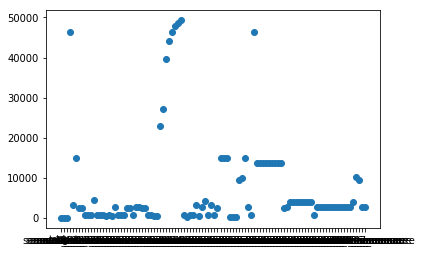

In [472]:
# plotting nan dist.
plt.scatter(range(len(nan_dist_train)), list(nan_dist_train.values()))
plt.xticks(range(len(nan_dist_train)), list(nan_dist_train.keys()))
plt.show()

### test

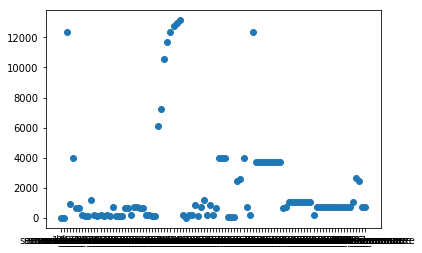

In [473]:
plt.scatter(range(len(nan_dist_test)), list(nan_dist_test.values()))
plt.xticks(range(len(nan_dist_test)), list(nan_dist_test.keys()))
plt.show()

### Finding the dist based on class:

### dropping nans

In [474]:
# drop the column if a percentage of the column (its rows) is na
# 2 percent
for i in df_train.columns:
    if df_train[i].isna().sum() > 0.10 * len(df_train):
        df_train.drop(i, axis=1, inplace=True)

In [475]:
# drop the column if a percentage of the column (its rows) is na
# 2 percent
for i in df_test.columns:
    if df_test[i].isna().sum() > 0.10 * len(df_test):
        df_test.drop(i, axis=1, inplace=True)

In [476]:
df_train.fillna(value=0, axis=1, inplace=True)
df_test.fillna(value=0, axis=1, inplace=True)

In [477]:
# the number of rows and columns after dropping the nans:
print("rows: ", len(df_train), "cols: ", len(df_train.columns))
print("rows: ", len(df_test), "cols: ", len(df_test.columns))

rows:  60000 cols:  74
rows:  16001 cols:  73


In [478]:
# See if there are any nans left:
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


### plotting the number of zeros vs non-zeros per column

In [479]:
zero_dist_train = {}
zero_dist_test = {}

for i in df_train.columns:
    if 0 in df_train[i].value_counts():    
        zero_dist_train[i] = df_train[i].value_counts()[0]
        
for i in df_test.columns:
    if 0 in df_train[i].value_counts():    
        zero_dist_test[i] = df_train[i].value_counts()[0]

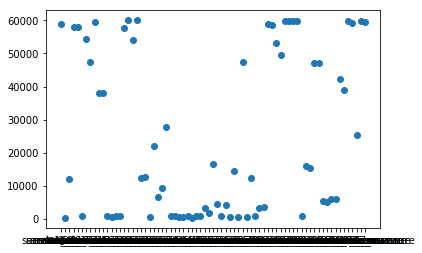

In [480]:
plt.scatter(range(len(zero_dist_train)), list(zero_dist_train.values()))
plt.xticks(range(len(zero_dist_train)), list(zero_dist_train.keys()))
plt.show()

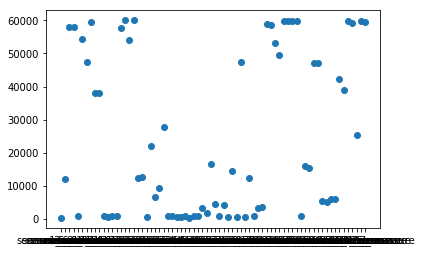

In [481]:
plt.scatter(range(len(zero_dist_test)), list(zero_dist_test.values()))
plt.xticks(range(len(zero_dist_test)), list(zero_dist_test.keys()))
plt.show()

In [482]:
# the number of rows and columns before dropping the nans:
print("TRAIN: ", "rows: ", len(df_train), "cols: ", len(df_train.columns))
print("TEST: ", "rows: ", len(df_test), "cols: ", len(df_test.columns))

TRAIN:  rows:  60000 cols:  74
TEST:  rows:  16001 cols:  73


In [483]:
# dropping the columns with more than 50 percent zeros:
extra_zero_train = [i for i in zero_dist_train if (zero_dist_train[i] < 0.80 * len(df_train)) or i == 'target' or i == 'id']
extra_zero_test = [i for i in zero_dist_test if (zero_dist_test[i] < 0.80 * len(df_test)) or i == 'id']

extra_zero_train.append('id')
extra_zero_test.append('id')

df_train = df_train[extra_zero_train]
df_test = df_test[extra_zero_test]

In [484]:
# the number of rows and columns before dropping the nans:
print("TRAIN: ", "rows: ", len(df_train), "cols: ", len(df_train.columns))
print("TEST: ", "rows: ", len(df_test), "cols: ", len(df_test.columns))

TRAIN:  rows:  60000 cols:  54
TEST:  rows:  16001 cols:  38


# Sampling

In [485]:
# 30
zero_index = np.array([i for i in df_train[df_train.target == 0].index])
zero_index = np.random.choice(zero_index, int(0.40 * len(zero_index)), replace = False)
df_train = pd.concat([df_train[df_train.target == 1], df_train.loc[zero_index]])

In [486]:
df_train.target.value_counts()

0.0    23600
1.0     1000
Name: target, dtype: int64

# Corr

In [487]:
# import seaborn as sns
# #Using Pearson Correlation
# plt.figure(figsize=(12,10))
# cor = df_train_copy.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [488]:
# #Correlation with output variable
# cor_target = abs(cor["target"])
# #Selecting highly correlated features
# relevant_features = cor_target[cor_target>0.4]
# col_list = relevant_features.index.tolist()
# col_list.append('id')
# df_train=df_train[col_list]

# Adding some new features

In [489]:
# # sensor61_measure, sensor17_measure, sensor35_measure
# df_train['sensor35_measure_2'] = df_train.sensor35_measure * df_train.sensor17_measure
# df_train['sensor35_measure_3'] = df_train.sensor35_measure * df_train.sensor35_measure
# df_train['sensor35_measure_4'] = df_train.sensor17_measure * df_train.sensor61_measure
# df_train['sensor35_measure_5'] = df_train.sensor1_measure * df_train.sensor1_measure
# df_train['sensor35_measure_6'] = df_train.sensor17_measure * df_train.sensor17_measure

# df_train['sensor35_measure_5'] = df_train.sensor1_measure * df_train.sensor1_measure
# df_train['sensor35_measure_6'] = df_train.sensor1_measure * df_train.sensor35_measure
# df_train['sensor35_measure_7'] = df_train.sensor16_measure * df_train.sensor35_measure




# df_train['sensor17_measure_2'] = df_train.sensor17_measure * df_train.sensor61_measure
# df_train['sensor35_measure_2'] = df_train.sensor35_measure * df_train.sensor17_measure


In [490]:
# Create correlation matrix
corr_matrix = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_train.drop(df_train[to_drop], axis=1, inplace=True)

In [491]:
df_train

,target,sensor1_measure,sensor3_measure,sensor8_measure,sensor10_measure,sensor12_measure,sensor16_measure,sensor17_measure,sensor22_measure,sensor23_measure,...,sensor90_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor102_measure,id
9,1.0,153204.0,1.820000e+02,2658638.0,0.0,29384.0,1571480.0,1120644.0,1368.0,862.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
23,1.0,453236.0,2.926000e+03,18489312.0,0.0,117902.0,5348896.0,3667892.0,24514.0,1858.0,...,169964.0,73289586.0,16623244.0,1056682.0,93686740.0,28423762.0,7966.0,382610.0,432739640.0,24.0
60,1.0,72504.0,1.594000e+03,0.0,0.0,0.0,0.0,0.0,6488.0,1414.0,...,42400.0,0.0,0.0,339296.0,88760.0,10772.0,0.0,0.0,1550150.0,61.0
115,1.0,762958.0,0.000000e+00,14649948.0,0.0,5043850.0,11311258.0,4023056.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0
135,1.0,695994.0,0.000000e+00,30746644.0,402.0,248428.0,20596998.0,10304200.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0
156,1.0,1056758.0,4.232800e+04,39454610.0,2782.0,4715344.0,39047734.0,10263578.0,34274.0,13358.0,...,351394.0,134116954.0,17043728.0,1424784.0,5243680.0,5958964.0,25101716.0,1144778.0,0.0,157.0
177,1.0,361638.0,2.800000e+02,14390070.0,122.0,640976.0,7930028.0,3690164.0,684.0,102.0,...,12146.0,4536022.0,708268.0,76250.0,2819000.0,450506.0,2326980.0,1932.0,0.0,178.0
210,1.0,791254.0,0.000000e+00,16175962.0,0.0,4115140.0,13792288.0,4396396.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.0
251,1.0,1053152.0,0.000000e+00,16955528.0,426786.0,0.0,8702712.0,3872498.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0
310,1.0,785270.0,0.000000e+00,21002694.0,12830.0,5792164.0,17820990.0,4131950.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,311.0


In [492]:
# # modify training set
# df_train = df_train[['sensor17_measure',
#  'sensor1_measure',
#  'sensor35_measure',
#  'sensor61_measure',
#  'sensor34_measure',
#  'sensor8_measure']]

# df_test = df_test[['sensor17_measure',
#  'sensor1_measure',
#  'sensor35_measure',
#  'sensor61_measure',
#  'sensor34_measure',
#  'sensor8_measure']]

# train set

In [493]:
# train set
y_train = df_train['target']
ids_train = df_train['id']

df_train.drop('id', axis=1, inplace=True)
df_train.drop('target', axis=1, inplace=True)

# print(df_train.head())

X_train = df_train.values

# test set
ids_test = df_test['id']
# print(df_test.head())
df_test.drop('id', axis=1, inplace=True)

X_test = df_test.values

# Scaling

In [494]:
# Scaler models:
scaler_model = StandardScaler()

In [495]:
# sensor61_measure, sensor17_measure, sensor35_measure
# df_train['sensor35_measure_2'] = df_train.sensor35_measure * df_train.sensor35_measure
# df_train['sensor35_measure_3'] = df_train.sensor35_measure * df_train.sensor17_measure
# df_train['sensor35_measure_4'] = df_train.sensor35_measure * df_train.sensor1_measure
# df_train['sensor35_measure_5'] = df_train.sensor1_measure * df_train.sensor17_measure
# df_train['sensor35_measure_6'] = df_train.sensor17_measure * df_train.sensor17_measure


# df_train['sensor35_measure_22'] = df_train.sensor35_measure * df_train.sensor35_measure_3
# df_train['sensor35_measure_33'] = df_train.sensor35_measure * df_train.sensor35_measure_6
# df_train['sensor35_measure_44'] = df_train.sensor17_measure * df_train.sensor35_measure_3
# df_train['sensor35_measure_55'] = df_train.sensor1_measure * df_train.sensor35_measure_5
# df_train['sensor35_measure_66'] = df_train.sensor17_measure * df_train.sensor35_measure_5

# df_train['sensor35_measure_24'] = df_train.sensor17_measure * df_train.sensor35_measure_55
# df_train['sensor35_measure_34'] = df_train.sensor35_measure * df_train.sensor35_measure_33
# df_train['sensor35_measure_45'] = df_train.sensor35_measure * df_train.sensor35_measure_66
# df_train['sensor35_measure_56'] = df_train.sensor1_measure * df_train.sensor17_measure
# df_train['sensor35_measure_67'] = df_train.sensor17_measure + df_train.sensor17_measure


# df_train['sensor35_measure_221'] = df_train.sensor35_measure * df_train.sensor35_measure_3
# df_train['sensor35_measure_331'] = df_train.sensor35_measure * df_train.sensor35_measure_6
# df_train['sensor35_measure_441'] = df_train.sensor17_measure * df_train.sensor35_measure_3
# df_train['sensor35_measure_551'] = df_train.sensor1_measure * df_train.sensor35_measure_5
# df_train['sensor35_measure_661'] = df_train.sensor17_measure * df_train.sensor35_measure_5

In [496]:
X_train_internal, X_test_internal, y_train_interal, y_test_interal = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [497]:
scaler_model.fit(X_train_internal)

X_train_internal = scaler_model.transform(X_train_internal)
X_test_internal = scaler_model.transform(X_test_internal)
# X_test = scaler_model.transform(X_test)

# feature_importances = pd.DataFrame(ad_hocModel.feature_importances_, index = df_train.columns, columns=['importance']).sort_values('importance', ascending=False)
# cols_to_train = feature_importances[:10].index.tolist()

In [498]:
# ADHOC RF
from sklearn.ensemble import AdaBoostClassifier
ad_hocModel_2 = AdaBoostClassifier()
ad_hocModel_2.fit(X_train_internal, y_train_interal)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Normalized confusion matrix
[[0.99025217 0.00974783]
 [0.21890547 0.78109453]]


NameError: name 'ad_hocModel' is not defined

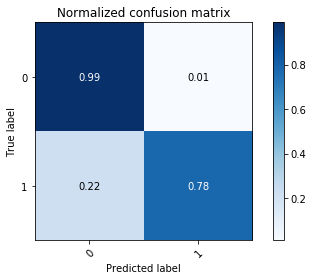

In [499]:

y_adhoc_pred = ad_hocModel_2.predict(X_test_internal)

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test_interal, y_adhoc_pred, normalize=True,
                      title='Normalized confusion matrix')


y_pred_test = ad_hocModel.predict(X_test)
df_out = pd.DataFrame({'id': ids_test, 'target': y_pred_test}, dtype=int)
df_out.to_csv('out.csv', index=None)

In [ ]:
# ADHOC RF
ad_hocModel = RandomForestClassifier(max_depth=4, random_state=0)
ad_hocModel.fit(X_train_internal, y_train_interal)

In [ ]:

y_adhoc_pred = ad_hocModel.predict(X_test_internal)

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test_interal, y_adhoc_pred, normalize=True,
                      title='Normalized confusion matrix')


y_pred_test = ad_hocModel.predict(X_test)
df_out = pd.DataFrame({'id': ids_test, 'target': y_pred_test}, dtype=int)
df_out.to_csv('out.csv', index=None)

In [ ]:
import pandas as pd
feature_importances = pd.DataFrame(ad_hocModel.feature_importances_,
                                   index = df_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

## PCA

In [ ]:
pca_train_internal = PCA(n_components=3).fit(X_train_internal)
pca_test_internal = PCA(n_components=3).fit(X_test_internal)
pca_test = PCA(n_components=3).fit(X_test)

X_train_internal_pca = pca_train_internal.transform(X_train_internal)
X_test_internal_pca = pca_test_internal.transform(X_test_internal)
X_test_pca = pca_test.transform(X_test)

In [ ]:
pca_test.explained_variance_ratio_

In [ ]:
plt.scatter(X_train_internal_pca[:, 0], X_train_internal_pca[:, 1])

# Model

In [500]:
# model = RandomForestClassifier(max_depth=4)
model = RandomForestClassifier(max_depth=10)
model.fit(X_train_internal_pca, y_train_interal)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [501]:
y_pred_train_interal = model.predict(X_train_internal_pca)
y_pred_test_interal = model.predict(X_test_internal_pca)

# Eval

In [502]:
f1_score(y_pred=y_pred_train_interal, y_true=y_train_interal, average='binary') 

0.8591639871382637

In [503]:
f1_score(y_pred=y_pred_test_interal, y_true=y_test_interal, average='binary') 

0.5014577259475218

In [504]:
accuracy_score(y_pred=y_pred_train_interal, y_true=y_train_interal)

0.9888719512195122

In [505]:
accuracy_score(y_pred=y_pred_test_interal, y_true=y_test_interal)

0.9652439024390244

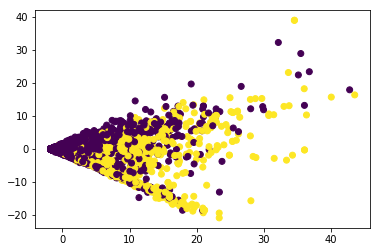

In [506]:
plt.scatter(X_train_internal_pca[:, 0], X_train_internal_pca[:, 1], c=y_train_interal)

Normalized confusion matrix
[[0.98813308 0.01186692]
 [0.5721393  0.4278607 ]]


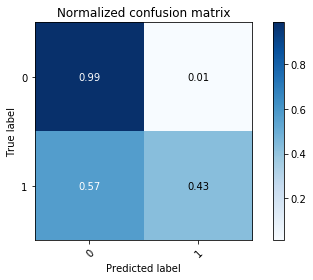

In [507]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test_interal, y_pred_test_interal, normalize=True,
                      title='Normalized confusion matrix')


# Export

In [508]:
y_pred_test = model.predict(X_test_pca)

In [509]:
df_out = pd.DataFrame({'id': ids_test, 'target': y_pred_test}, dtype=int)
df_out.to_csv('out.csv', index=None)

In [510]:
(y_pred_test == 1).sum()

122

In [511]:
y_pred_test_prob = model.predict_proba(X_test_pca)

In [512]:
y_pred_test_prob

array([[6.00000000e-01, 4.00000000e-01],
       [9.99422584e-01, 5.77416035e-04],
       [9.00000000e-01, 1.00000000e-01],
       ...,
       [9.00000000e-01, 1.00000000e-01],
       [6.00000000e-01, 4.00000000e-01],
       [6.00000000e-01, 4.00000000e-01]])

In [513]:
import pickle
filename = "RF_model.pkl"
pickle.dump(model, open(filename, "wb"))

In [514]:
np.savetxt("test.csv", X_test_pca, delimiter=",")

# Another Model

In [546]:
# model = RandomForestClassifier(max_depth=4)
model = MLPClassifier(alpha=.93)
model.fit(X_train_internal_pca, y_train_interal)

MLPClassifier(activation='relu', alpha=0.93, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [547]:
y_pred_train_interal = model.predict(X_train_internal_pca)
y_pred_test_interal = model.predict(X_test_internal_pca)

In [548]:
f1_score(y_pred=y_pred_train_interal, y_true=y_train_interal, average='binary') 

0.6747720364741642

In [549]:
f1_score(y_pred=y_pred_test_interal, y_true=y_test_interal, average='binary') 

0.6997518610421836

In [550]:
accuracy_score(y_pred=y_pred_train_interal, y_true=y_train_interal)

0.9728150406504065

In [551]:
accuracy_score(y_pred=y_pred_test_interal, y_true=y_test_interal)

0.9754065040650407

In [552]:
y_pred_test = model.predict(X_test_pca)

In [553]:
df_out = pd.DataFrame({'id': ids_test, 'target': y_pred_test}, dtype=int)
df_out.to_csv('out.csv', index=None)

In [554]:
(y_pred_test == 1).sum()

2533

Normalized confusion matrix
[[0.98707353 0.01292647]
 [0.29850746 0.70149254]]


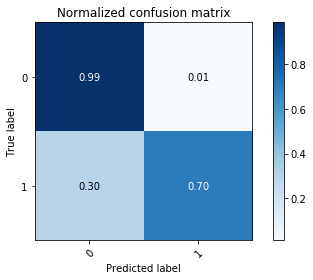

In [555]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test_interal, y_pred_test_interal, normalize=True,
                      title='Normalized confusion matrix')
